In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [1]:
import os
# print(os.path.exists('/content/drive/MyDrive/Colab-Notebooks/covidDataset'))
datapath = "../../../../datasets/covidDataset"
# datapath = '/content/drive/MyDrive/Colab-Notebooks/covidDataset'
print(os.path.exists(datapath))

True


In [2]:
import tensorflow as tf

In [3]:
#if set_memory_growth is enabled, the runtime initialization will not allocate all memory on the device. 
#Memory growth cannot be configured on a PhysicalDevice with virtual devices configured.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:
import pathlib

def get_imagepath_and_labels(datapath):
    data_root = pathlib.Path(datapath)
    all_image_path = [str(path) for path in list(data_root.glob('*/*'))]

    label_names = sorted(item.name for item in data_root.glob('*/*'))

    all_image_label = [pathlib.Path(single_image_path).parent.name for single_image_path in all_image_path]

    return all_image_path, all_image_label

all_image_path, all_image_label = get_imagepath_and_labels(datapath)

In [5]:
import numpy as np

def get_images_and_labels_astensor(image_path, image_labels, target_size, channels):
    '''
    target_size is to resize the image.
    '''
    images = []
    labels = []
    for i in range(0, len(image_path)):
        image = image_astensor(image_path[i], target_size, channels=channels)
        images.append(image)
        labels.append(image_labels[i])
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

def image_astensor(image_path, target_size, channels):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=channels)
        image = tf.image.resize(image, target_size)
        image = tf.cast(image, tf.float32 )
        image = image / 255
        return image

images, labels = get_images_and_labels_astensor(all_image_path, all_image_label, (224, 224), channels=3)

print(images.shape)
print(labels.shape)

(2481, 224, 224, 3)
(2481,)


In [6]:
print(np.unique(labels, return_counts=True))

(array(['COVID', 'non-COVID'], dtype='<U9'), array([1252, 1229]))


In [7]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    images, 
    labels, 
    test_size=400, 
    shuffle=True,
    random_state=42,
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2081, 224, 224, 3)
(2081,)
(400, 224, 224, 3)
(400,)


In [8]:
print(np.unique(y_test, return_counts=True))
print(np.unique(y_train, return_counts=True))

(array(['COVID', 'non-COVID'], dtype='<U9'), array([210, 190]))
(array(['COVID', 'non-COVID'], dtype='<U9'), array([1042, 1039]))


In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train, 
    test_size=200, 
    shuffle=True,
    random_state=42,
)

y_valid = np.expand_dims(y_valid, axis=1)
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_valid.shape)
print(y_valid.shape)

(1881, 224, 224, 3)
(1881, 1)
(400, 224, 224, 3)
(400, 1)
(200, 224, 224, 3)
(200, 1)


In [11]:
print(np.unique(y_valid, return_counts=True))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True)) 

(array(['COVID', 'non-COVID'], dtype='<U9'), array([104,  96]))
(array(['COVID', 'non-COVID'], dtype='<U9'), array([938, 943]))
(array(['COVID', 'non-COVID'], dtype='<U9'), array([210, 190]))


In [12]:
# to suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [13]:
from sklearn.preprocessing import LabelEncoder
# prepare target

def prepare_targets(y_train, y_test, y_valid):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    y_valid_enc = le.transform(y_valid)
    return y_train_enc, y_test_enc, y_valid_enc

y_train_enc, y_test_enc, y_valid_enc = prepare_targets(y_train, y_test, y_valid)

In [14]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train_enc, 2)
y_test_cat = to_categorical(y_test_enc, 2)
y_valid_cat = to_categorical(y_valid_enc, 2)

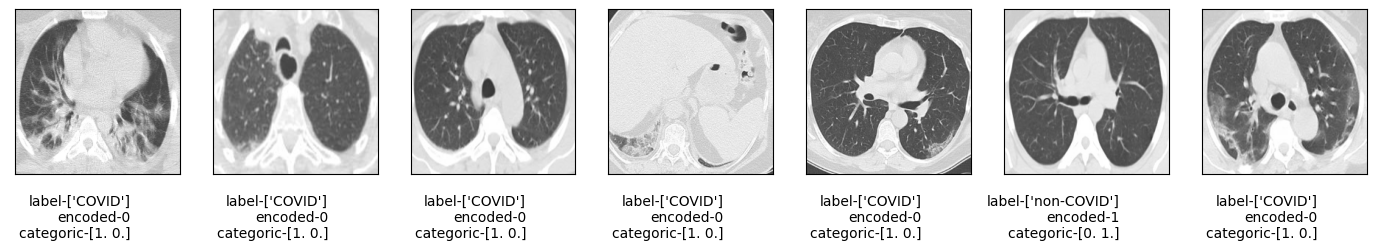

In [14]:
import matplotlib.pyplot as plt
n = 8
plt.figure(figsize=(20, 4))

for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_train[i])
    ax.text(0.7, -0.4, "label-{0}\nencoded-{1}\ncategoric-{2}".format(y_train[i], y_train_enc[i], y_train_cat[i]),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, fontsize=10)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Plotting implementation

In [15]:
import matplotlib.pyplot as plt
def plot_accuracy_and_loss(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '--r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, '--r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Model Implementation

Loading vgg19 and adding layers

In [26]:
vgg_model = tf.keras.applications.VGG19(weights='imagenet',
                                      include_top=False,
                                        input_shape=(224, 224, 3))
# vgg_model.summary()
vgg_model.trainable=False 

x = vgg_model.layers[-1].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1000, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(200, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
vgg_output = tf.keras.layers.Dense(2, activation='softmax')(x)

vgg = tf.keras.models.Model(vgg_model.input, vgg_output)
vgg._name='vgg19'
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
model_checkpoint_path = 'models/test4/vgg'
## callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=model_checkpoint_path,
                                                    save_weights_only=False,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    save_best_only=True)
model_earlystopping_callback = tf.keras.callbacks.EarlyStopping(
                                                    monitor='val_loss',
                                                    patience = 5,
                                                    mode='min')

In [28]:
vgg.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

vgg_history = vgg.fit(X_train, y_train_cat,
                    epochs=20,
                    batch_size = 16,
                    validation_data=(X_valid, y_valid_cat),
                     callbacks = [model_checkpoint_callback, model_earlystopping_callback])

Epoch 1/20
118/118 [==============================] - 417s 2s/step - loss: 1.6060 - binary_accuracy: 0.5566 - val_loss: 0.5901 - val_binary_accuracy: 0.8300
Epoch 2/20
118/118 [==============================] - 161s 1s/step - loss: 0.5492 - binary_accuracy: 0.7310 - val_loss: 0.4187 - val_binary_accuracy: 0.8450
Epoch 3/20
118/118 [==============================] - 146s 1s/step - loss: 0.4604 - binary_accuracy: 0.7799 - val_loss: 0.3648 - val_binary_accuracy: 0.8500
Epoch 4/20
118/118 [==============================] - 151s 1s/step - loss: 0.4030 - binary_accuracy: 0.8028 - val_loss: 0.3185 - val_binary_accuracy: 0.9000
Epoch 5/20
118/118 [==============================] - 138s 1s/step - loss: 0.4171 - binary_accuracy: 0.8054 - val_loss: 0.3262 - val_binary_accuracy: 0.8850
Epoch 6/20
118/118 [==============================] - 152s 1s/step - loss: 0.4159 - binary_accuracy: 0.8017 - val_loss: 0.2676 - val_binary_accuracy: 0.8900
Epoch 7/20
118/118 [==============================] - 146s

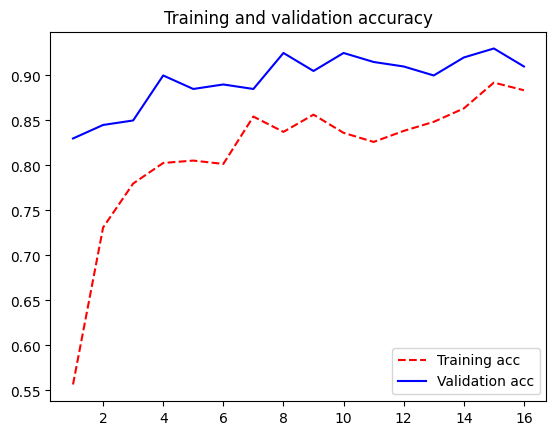

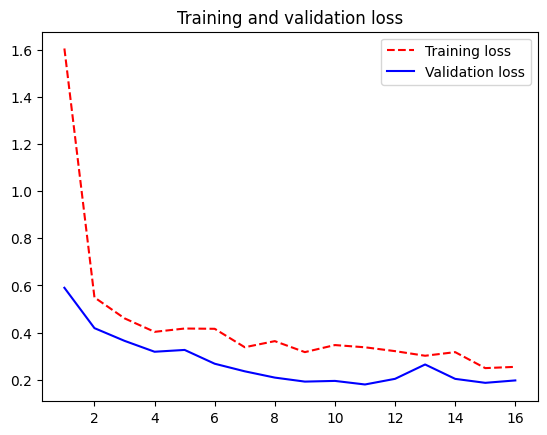

In [29]:
plot_accuracy_and_loss(vgg_history)

Part 2 - DenseNet 169 

In [16]:
dense169_model = tf.keras.applications.DenseNet169(weights='imagenet',
                                      include_top=False,
                                        input_shape=(224, 224, 3)
                                      )
# dense169_model.summary()
dense169_model.trainable=False 

y = dense169_model.layers[-1].output
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.Dropout(0.5)(y)
y = tf.keras.layers.Dense(1000, activation='relu')(y)
y = tf.keras.layers.Dropout(0.5)(y)
densenet_1_output = tf.keras.layers.Dense(2, activation='softmax')(y)

densenet_1 = tf.keras.models.Model(dense169_model.input, densenet_1_output)
densenet_1._name='densenet_1'
densenet_1.summary()

Model: "densenet_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                         

 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 128)    81920       ['conv5_block1_0_relu[0][0]']    
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_blo

In [17]:
model_checkpoint_path = 'models/test4/densenet-1000'
## callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=model_checkpoint_path,
                                                    save_weights_only=False,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    save_best_only=True)

In [18]:
densenet_1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

densenet_1_history = densenet_1.fit(X_train, y_train_cat,
                    epochs=20,
                    batch_size=1,
                    validation_data=(X_valid, y_valid_cat),
                   callbacks = model_checkpoint_callback)

Epoch 1/20
1881/1881 [==============================] - 982s 502ms/step - loss: 5.5766 - binary_accuracy: 0.7650 - val_loss: 0.3525 - val_binary_accuracy: 0.8350
Epoch 2/20
1881/1881 [==============================] - 762s 392ms/step - loss: 0.5257 - binary_accuracy: 0.8166 - val_loss: 0.7612 - val_binary_accuracy: 0.6900
Epoch 3/20
1881/1881 [==============================] - 835s 444ms/step - loss: 0.4731 - binary_accuracy: 0.8208 - val_loss: 0.1970 - val_binary_accuracy: 0.9450
Epoch 4/20
1881/1881 [==============================] - 662s 348ms/step - loss: 0.7179 - binary_accuracy: 0.8123 - val_loss: 0.4119 - val_binary_accuracy: 0.8100
Epoch 5/20
1881/1881 [==============================] - 662s 352ms/step - loss: 0.3975 - binary_accuracy: 0.8426 - val_loss: 0.2903 - val_binary_accuracy: 0.8750
Epoch 6/20
1881/1881 [==============================] - 805s 428ms/step - loss: 0.4241 - binary_accuracy: 0.8591 - val_loss: 0.1300 - val_binary_accuracy: 0.9400
Epoch 7/20
1881/1881 [======

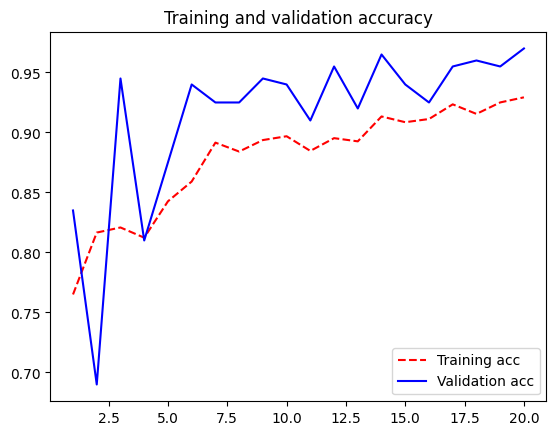

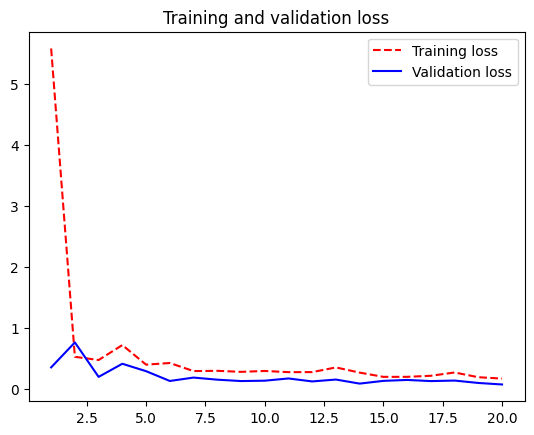

In [19]:
plot_accuracy_and_loss(densenet_1_history)

Part 3 - Densenet 169

In [15]:
dense169_model2 = tf.keras.applications.DenseNet169(weights='imagenet',
                                      include_top=False,
                                        input_shape=(224, 224, 3)
                                      )
# dense169_model.summary()
dense169_model2.trainable=False 
# since the model is already loaded we load in again
z = dense169_model2.layers[-1].output
z = tf.keras.layers.Flatten()(z)
z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(1000, activation='relu')(z)
z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(500, activation='relu')(z)
z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(200, activation='relu')(z)
z = tf.keras.layers.Dropout(0.5)(z)
densenet_2_output = tf.keras.layers.Dense(2, activation='softmax')(z)

densenet_2 = tf.keras.models.Model(dense169_model2.input, densenet_2_output)
densenet_2._name='densenet_2'
densenet_2.summary()

Model: "densenet_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                         

 conv5_block3_0_bn (BatchNormal  (None, 7, 7, 704)   2816        ['conv5_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_0_relu (Activatio  (None, 7, 7, 704)   0           ['conv5_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 128)    90112       ['conv5_block3_0_relu[0][0]']    
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
          

In [16]:
model_checkpoint_path = 'models/test4/densenet-1000-500-200'
## callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=model_checkpoint_path,
                                                    save_weights_only=False,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    save_best_only=True)

In [17]:
densenet_2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

densenet_2_history = densenet_2.fit(X_train, y_train_cat,
                    epochs=20,
                    batch_size = 1,
                    validation_data=(X_valid, y_valid_cat),
                    callbacks = model_checkpoint_callback )

Epoch 1/20
1881/1881 [==============================] - 1397s 657ms/step - loss: 5.6831 - binary_accuracy: 0.6018 - val_loss: 0.6649 - val_binary_accuracy: 0.5750
Epoch 2/20
1881/1881 [==============================] - 894s 470ms/step - loss: 0.7733 - binary_accuracy: 0.5901 - val_loss: 0.5786 - val_binary_accuracy: 0.6600
Epoch 3/20
1881/1881 [==============================] - 844s 442ms/step - loss: 0.7123 - binary_accuracy: 0.6077 - val_loss: 0.5406 - val_binary_accuracy: 0.7650
Epoch 4/20
1881/1881 [==============================] - 879s 461ms/step - loss: 0.7139 - binary_accuracy: 0.6183 - val_loss: 0.4762 - val_binary_accuracy: 0.7700
Epoch 5/20
1881/1881 [==============================] - 708s 366ms/step - loss: 0.6424 - binary_accuracy: 0.6225 - val_loss: 0.4914 - val_binary_accuracy: 0.7750
Epoch 6/20
1881/1881 [==============================] - 693s 369ms/step - loss: 0.6559 - binary_accuracy: 0.6364 - val_loss: 0.5451 - val_binary_accuracy: 0.6800
Epoch 7/20
1881/1881 [=====

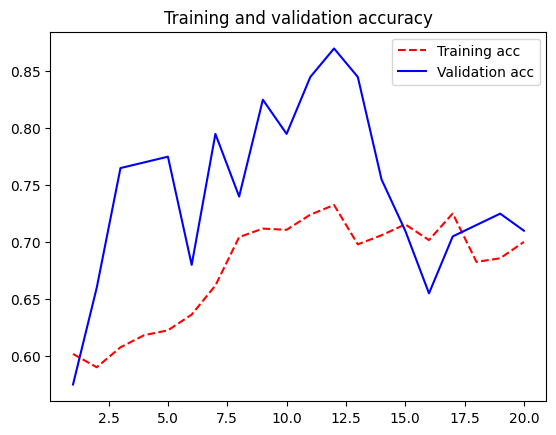

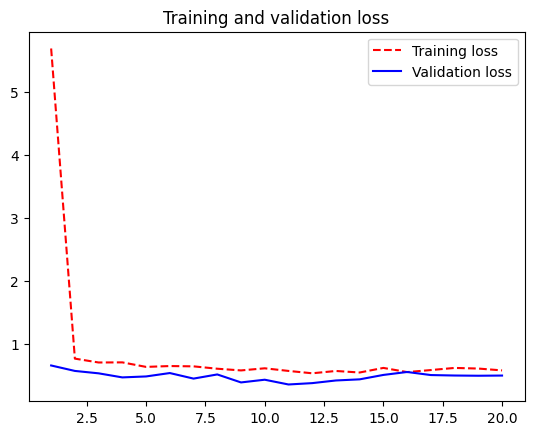

In [22]:
plot_accuracy_and_loss(densenet_2_history)

Ensembling all the models

In [16]:
vgg = tf.keras.models.load_model('models/test4/vgg')
densenet_1 = tf.keras.models.load_model('models/test4/densenet-1000')
densenet_2 = tf.keras.models.load_model('models/test4/densenet-1000-500-200')

In [17]:
vgg.trainable = False
densenet_1.trainable = False
densenet_2.trainable = False
models = [vgg, densenet_1, densenet_2]
# to avoid conflicts with naming
for layer in models[0].layers:
    layer._name = layer.name + str('_0')
for layer in models[1].layers:
    layer._name = layer.name + str('_1')
for layer in models[2].layers:
    layer._name = layer.name + str('_2')

In [18]:
average = tf.keras.layers.Average()([vgg.output, densenet_1.output, densenet_2.output])
dense = tf.keras.layers.Dense(1, activation='sigmoid')(average)

ensemble = tf.keras.Model([vgg.input, densenet_1.input, densenet_2.input], dense)

In [19]:
ensemble.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_2 (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_1_2[0][0]']              
 D)                                                                                               
                                                                                                  
 conv1/conv_2 (Conv2D)          (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                             

 conv4_block5_0_bn_1 (BatchNorm  (None, 14, 14, 384)  1536       ['conv4_block4_concat_1[0][0]']  
 alization)                                                                                       
                                                                                                  
 conv4_block5_1_relu_2 (Activat  (None, 14, 14, 128)  0          ['conv4_block5_1_bn_2[0][0]']    
 ion)                                                                                             
                                                                                                  
 conv4_block5_0_relu_1 (Activat  (None, 14, 14, 384)  0          ['conv4_block5_0_bn_1[0][0]']    
 ion)                                                                                             
                                                                                                  
 conv4_block5_2_conv_2 (Conv2D)  (None, 14, 14, 32)  36864       ['conv4_block5_1_relu_2[0][0]']  
          

                                                                                                  
 conv4_block27_0_relu_1 (Activa  (None, 14, 14, 1088  0          ['conv4_block27_0_bn_1[0][0]']   
 tion)                          )                                                                 
                                                                                                  
 conv4_block27_2_conv_2 (Conv2D  (None, 14, 14, 32)  36864       ['conv4_block27_1_relu_2[0][0]'] 
 )                                                                                                
                                                                                                  
 conv4_block27_1_conv_1 (Conv2D  (None, 14, 14, 128)  139264     ['conv4_block27_0_relu_1[0][0]'] 
 )                                                                                                
                                                                                                  
 conv4_blo

 )                                                                                                
                                                                                                  
 conv5_block13_1_conv_2 (Conv2D  (None, 7, 7, 128)   131072      ['conv5_block13_0_relu_2[0][0]'] 
 )                                                                                                
                                                                                                  
 conv5_block12_concat_1 (Concat  (None, 7, 7, 1024)  0           ['conv5_block11_concat_1[0][0]', 
 enate)                                                           'conv5_block12_2_conv_1[0][0]'] 
                                                                                                  
 conv5_block13_1_bn_2 (BatchNor  (None, 7, 7, 128)   512         ['conv5_block13_1_conv_2[0][0]'] 
 malization)                                                                                      
          

Total params: 234,677,353
Trainable params: 3
Non-trainable params: 234,677,350
__________________________________________________________________________________________________


In [31]:
# from keras.utils.vis_utils import plot_model

In [32]:
# plot_model(ensembled, to_file = 'new_model.png', dpi=50)

In [20]:
ensemble.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [21]:
model_checkpoint_path = 'models/test4/ensemble'
## callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=model_checkpoint_path,
                                                    save_weights_only=False,
                                                    monitor='val_loss',
                                                    mode='min',
                                                    save_best_only=True)

In [23]:
ensembled_history = ensemble.fit([X_train, X_train, X_train],y_train_enc,
                                epochs=20,
                                validation_data=([X_valid, X_valid, X_valid], y_valid_enc),
                                batch_size = 1,
                                callbacks=model_checkpoint_callback)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
# plot_accuracy_and_loss(ensembled_history)

In [ ]:
# test_loss, test_acc = ensemble.evaluate([X_test, X_test, X_test],  y_test_enc)
# print('Accuracy:', test_acc)
# print('Loss: ', test_loss)

let's do some evauation

In [ ]:
import pandas as pd
from sklearn.metrics import recall_score ,precision_score,accuracy_score, f1_score,roc_auc_score

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [ ]:
def binary_classification_performance(y_test, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(accuracy_score(y_pred = y_pred, y_true = y_test),2)
    precision = round(precision_score(y_pred = y_pred, y_true = y_test),2)
    recall = round(recall_score(y_pred = y_pred, y_true = y_test),2)
    f1_score = round(2*precision*recall/(precision + recall),2)
    specificity = round(tn/(tn+fp),2)
    npv = round(tn/(tn+fn),2)
    auc_roc = round(roc_auc_score(y_score = y_pred, y_true = y_test),2)


    result = pd.DataFrame({'Accuracy' : [accuracy],
                         'Precision (or PPV)' : [precision],
                         'Recall (senitivity or TPR)' : [recall],
                         'f1 score' : [f1_score],
                         'AUC_ROC' : [auc_roc],
                         'Specificty (or TNR)': [specificity],
                         'NPV' : [npv],
                         'True Positive' : [tp],
                         'True Negative' : [tn],
                         'False Positive':[fp],
                         'False Negative':[fn]})
    return result

In [52]:
y_pred = ensemble.predict([X_test[:10], X_test[:10], X_test[:10]])

In [53]:
print(y_pred)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
